In [6]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

In [7]:
'''
在强化学习中，通常使用梯度下降算法来更新神经网络的参数，以最小化损失函数。然而，在连续动作空间中，我们需要从一个连续的动作分布中采样动作，以便在环境中执行这些动作。这个过程中，我们需要计算采样动作的梯度，以便更新策略网络的参数。但是，由于采样过程是不可导的，因此无法直接计算梯度。
为了解决这个问题，我们可以使用重参数化技巧。重参数化技巧将采样过程分解为两个部分：一个确定性的部分和一个随机的部分。确定性的部分可以通过神经网络计算，而随机的部分可以通过从一个固定的分布中采样得到。这样，我们就可以将采样过程转化为可导的操作，从而可以计算梯度。
在SAC算法中，我们使用高斯分布作为策略网络的输出分布。重参数化采样就是从高斯分布中采样一个动作的过程，其中均值和标准差是策略网络的输出。
'''

# 策略网络，其输入是状态，输出是动作和对应的对数概率
class PolicyNet_Continuous(torch.nn.Module): # 策略网络
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet_Continuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound # 动作的取值范围

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x) # 动作均值
        std = F.softplus(self.fc_std(x)) # 动作标准差
        dist = Normal(mu, std) # 生成均值为mu，标准差为std的正态分布
        normal_sample = dist.rsample()  # 重参数化采样，从高斯分布中采样一个动作
        log_prob = dist.log_prob(normal_sample) # 计算采样动作的对数概率
        action = torch.tanh(normal_sample) # 将采样动作经过tanh函数映射到[-1,1]区间
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7) # 计算tanh_normal分布的对数概率密度
        action = action * self.action_bound # 将动作映射到动作边界
        return action, log_prob # 返回动作和对应的对数概率

# 定义价值网络，其输入是状态和动作拼接后的向量，输出是该状态动作对的价值
class QValueNet_Continuous(torch.nn.Module): 
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet_Continuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [8]:
# 处理连续动作的 SAC 算法
class SAC_Continuous:
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNet_Continuous(state_dim, hidden_dim, action_dim, action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNet_Continuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNet_Continuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNet_Continuous(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet_Continuous(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值，可以使训练结果比较稳定。alpha是SAC中的正则话系数，用来控制策略的熵，从而控制策略的探索程度
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵
        self.gamma = gamma # 折扣因子
        self.tau = tau # 软更新的系数
        self.device = device

    # 根据当前策略采样动作
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0] # 采样动作
        return [action.item()]

    # 计算时序差分目标
    def calculate_target(self, rewards, next_states, dones):  
        next_actions, log_prob = self.actor(next_states) # 采样下一个状态的动作
        entropy = -log_prob # 计算动作的熵
        # 计算下一个状态的价值，使用两个目标Q网络中的最小值作为价值估计
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
        # 计算TD目标值，将下一个状态的价值与当前奖励相加，并乘以终止标志的衰减因子
        td_target = rewards + self.gamma * next_value * (1 - dones) 
        return td_target

    # 软更新目标网络
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0

        # 更新两个价值网络
        td_target = self.calculate_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(F.mse_loss(self.critic_2(states, actions), td_target.detach()))

        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        # 计算策略网络的损失函数，包括策略网络的熵和两个价值网络的的较小值
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - torch.min(q1_value, q2_value))

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新熵正则项的系数alpha
        alpha_loss = torch.mean((entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标价值网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [9]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0] # 目标熵
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SAC_Continuous(state_dim, hidden_dim, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it, episode=100, return=-208.579]


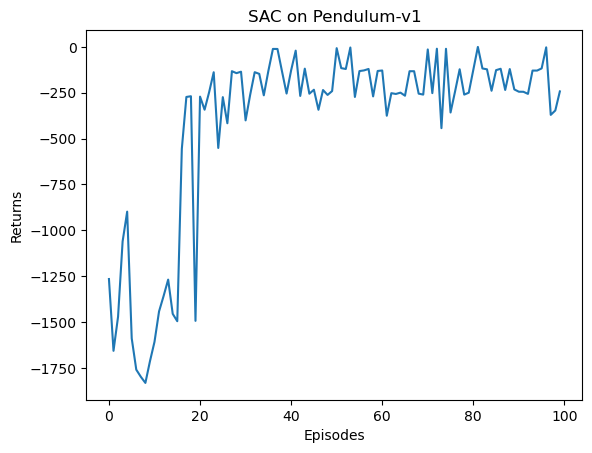

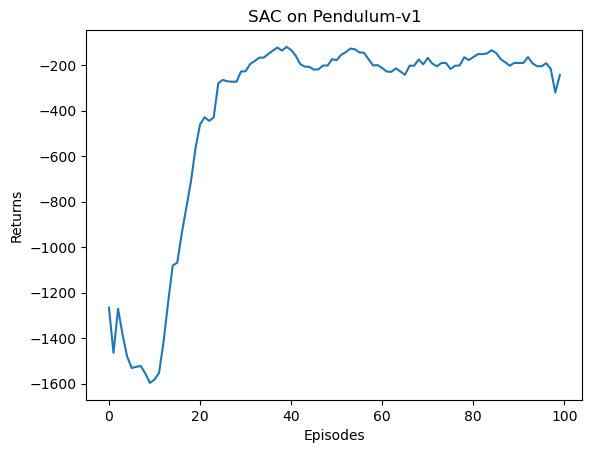

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [11]:
'''
SAC 算法原本是针对连续动作交互的环境提出的，SAC 处理与离散动作交互的环境需要做一些相应的修改。策略网络和价值网络的网络结构将发生如下改变：
1、策略网络的输出修改为在离散动作空间上的 softmax 分布
2、价值网络直接接收状态和离散动作空间的分布作为输入
'''

# 策略网络，其输入是状态，输出是动作的概率分布
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

# 价值网络，其输入是某个状态，输出则是状态的价值估计
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
# 处理离散动作的SAC算法
class SAC:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # 策略网络
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device) # 第一个Q网络
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device) # 第二个Q网络
        self.target_critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
        # 使用alpha的log值，可以使训练结果比较稳定。alpha是SAC中的正则话系数，用来控制策略的熵，从而控制策略的探索程度
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵
        self.gamma = gamma
        self.tau = tau
        self.device = device

    # 根据当前策略采样动作
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # 计算时序差分目标，直接用策略网络的输出概率进行期望计算
    def calculate_target(self, rewards, next_states, dones):
        next_probs = self.actor(next_states) # 采样下一个状态的动作的概率分布
        next_log_probs = torch.log(next_probs + 1e-8) # 计算对数概率
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True) # 计算动作的熵
        # 计算下一个状态的价值，使用两个目标Q网络中的最小值作为价值估计
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        # 计算TD目标值，将下一个状态的价值与当前奖励相加，并乘以终止标志的衰减因子
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    # 软更新目标网络
    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)  # 动作不再是float类型
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 更新两个价值网络
        td_target = self.calculate_target(rewards, next_states, dones)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(F.mse_loss(critic_1_q_values, td_target.detach()))

        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(F.mse_loss(critic_2_q_values, td_target.detach()))

        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()

        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True) # 计算动作的熵
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value), dim=1, keepdim=True)  
        # 计算策略网络的损失函数，包括策略网络的熵和两个价值网络的的较小值
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新熵正则项的系数alpha
        alpha_loss = torch.mean((entropy - target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        # 软更新目标价值网络
        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [13]:
actor_lr = 1e-3
critic_lr = 1e-2
alpha_lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 500
batch_size = 64
target_entropy = -1 # 目标熵
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = SAC(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 9: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s, episode=200, return=185.400]


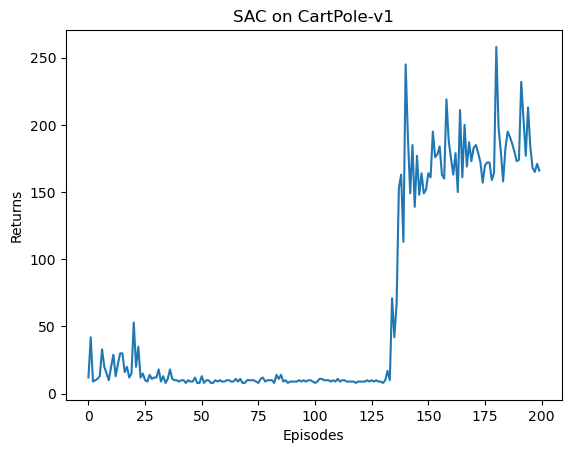

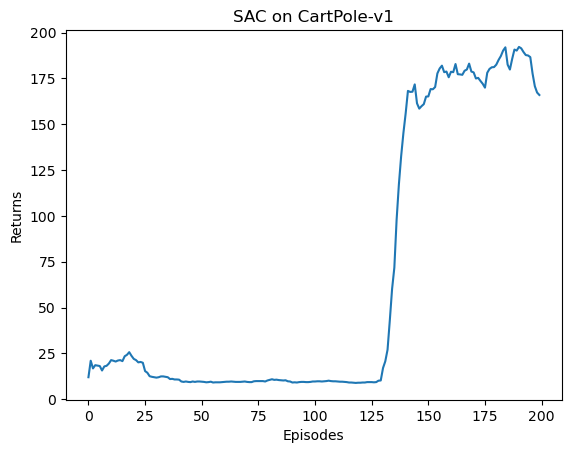

In [14]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()